title: Covid-19 -  Impact on MAU due to spending slowdown  
author: James Arch   
date: 2020-04-07   
region: EU   
link: https://docs.google.com/presentation/d/1uYEQup6AirmFFTQkaU1QPHfUrGctDghkogsxA1agFfs/edit?usp=sharing   
tags: product, growth, mau, retention, spending, card, churn, covid-19, coronavirus   
summary: Here we compare the differences in forecasting the Covid-19 between March 29th and April 6th 2020. We saw a good recovery between these 2 weeks in the number of users doing transactions - shown by almost linear increase in cumulative MAU day to day.

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize

# Overview

Given the recent down turn in transaction activity we have seen over the past weeks, below is a rough and ready analysis looking at the potential impact of the current lockdown on MAU numbers.

In [39]:
## Read data, I just extracted a csv but query is below
"""
with first_in_period as (
	select w.start_time::date as wk,
			w.end_time::date as w_e,
			z.user_created,
			uc.cluster_new as user_cluster,
			min(txn_ts::date) as min_txn
	from dwh_cohort_weeks as w
	inner join dbt.zrh_transactions as z
	on z.txn_ts between w.end_time - interval '35 days' and w.end_time 
	and activity_incl_flg is true
	inner join dbt.zrh_users as u
	on u.user_created = z.user_created
	and country_tnc_legal != 'GBR'
	where w.end_time <= current_date + interval '42_days'
	and w.end_time >= current_date - interval '200 days'
	and z.txn_ts < current_date
	group by 1,2,3,4)
, users_agg as (	
	select w_e,
		   min_txn as dt,
		   count(*) as users
	from first_in_period as p
	group by 1,2)	
select  w_e,
		dt,
		datediff('day',w_e,dt) as n,
		users,
	    sum(users) over (partition by w_e order by dt rows unbounded preceding) as cumul_users,
	    sum(users) over (partition by w_e ) as maus
from users_agg as a
order by 1,2
"""

df = pd.read_csv("total_cumul_mau_202004141949.csv")

## Exploratory analysis

In [40]:
df.head()

w_e          dt   n   users  cumul_users     maus
0  2019-09-29  2019-08-26 -34  312045       312045  1027782
1  2019-09-29  2019-08-27 -33  131567       443612  1027782
2  2019-09-29  2019-08-28 -32   82080       525692  1027782
3  2019-09-29  2019-08-29 -31   57721       583413  1027782
4  2019-09-29  2019-08-30 -30   53052       636465  1027782

In [41]:
df_plot = df[df["w_e"] >= "2020-03-15"]

In [42]:
df_plot.head()

w_e          dt   n   users  cumul_users     maus
840  2020-03-15  2020-02-10 -34  400855       400855  1236000
841  2020-03-15  2020-02-11 -33  169050       569905  1236000
842  2020-03-15  2020-02-12 -32   90978       660883  1236000
843  2020-03-15  2020-02-13 -31   67405       728288  1236000
844  2020-03-15  2020-02-14 -30   56244       784532  1236000

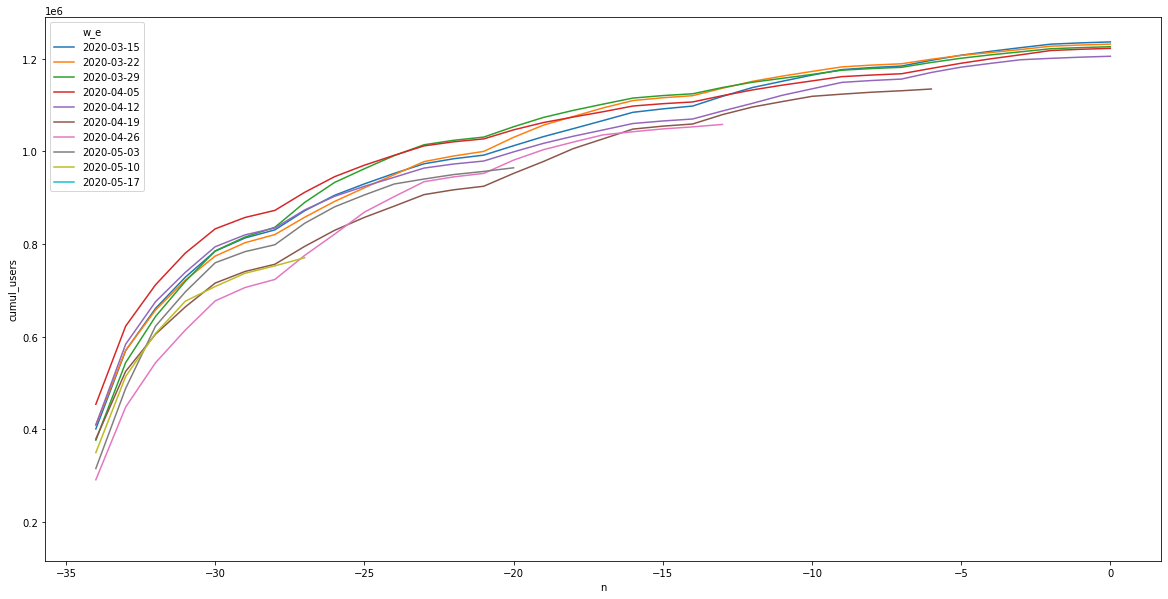

In [43]:
plt.figure(figsize=(20, 10))
ax = sns.lineplot(x="n", y="cumul_users", hue="w_e", data=df_plot)

In [44]:
## Testing fitting process
def log_func(x, a, b, c):
    return a * np.log(b * x) + c


df_test = df[df["w_e"] == "2020-03-22"]
df_test["n"] = df["n"] + 35

df_all = df_test
df_first = df_test[df_test["n"] <= 15]

x_data_all = df_all["n"]
y_data_all = df_all["cumul_users"]

x_data_first = df_first["n"]
y_data_first = df_first["cumul_users"]

params_all, params_covariance_all = optimize.curve_fit(log_func, x_data_all, y_data_all)
params_first, params_covariance_first = optimize.curve_fit(
    log_func, x_data_first, y_data_first
)

print(params_all)
print(params_first)

[ 2.40540717e+05  4.80605965e+01 -5.46207337e+05]
[ 2.24364337e+05  4.81966720e+01 -4.61881007e+05]


/home/jamesarch/environments/project_prophettest/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/jamesarch/environments/project_prophettest/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


## Lets define some functions to fit

In [45]:
def log_func_d(x, a, b, c, d):
    return a * np.log(b * (x + d)) + c


def log_func(x, a, b, c):
    return a * np.log(b * (x)) + c

In [46]:
## Lets define some functions to fit
def show_cohort(wk):
    """Pick one cohort and plot log fit line for 7,14,21,35 days of data"""
    df_test = df.loc[:][df["w_e"] == wk]
    df_test["n"] = df["n"] + 35
    x_data_all = df_test["n"]
    y_data_all = df_test["cumul_users"]

    plt.figure(figsize=(12, 8))

    for i, n in enumerate([7, 14, 21, 35]):
        df_fit = df_test[df_test["n"] <= n]
        x_data_fit = df_fit["n"]
        y_data_fit = df_fit["cumul_users"]

        params, params_covariance = optimize.curve_fit(log_func, x_data_fit, y_data_fit)

        print(params)

        x_axis = np.arange(35) + 1

        plt.plot(
            x_axis,
            log_func(x_axis, params[0], params[1], params[2]),
            label=f"Fit w. {n} days of data",
        )

    plt.scatter(x_data_all, y_data_all, label="Actuals", marker="x", color="black")
    plt.legend(loc="best")
    plt.xlabel("Days from 5 weeks prior")
    plt.ylabel("MAUs (mill.)")
    plt.title(f"Daily Cumulative MAU & curve for n days of data - {wk}")
    plt.show()

## Run for a few different weeks to check data

[ 2.25608442e+05  4.49984234e+01 -4.49607632e+05]
[ 2.24098069e+05  1.02213871e+02 -6.26228724e+05]
[ 2.26133616e+05  5.16145579e+01 -4.83977916e+05]


/home/jamesarch/environments/project_prophettest/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jamesarch/environments/project_prophettest/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jamesarch/environments/project_prophettest/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


[ 2.36824370e+05  4.93813928e+01 -5.33144556e+05]


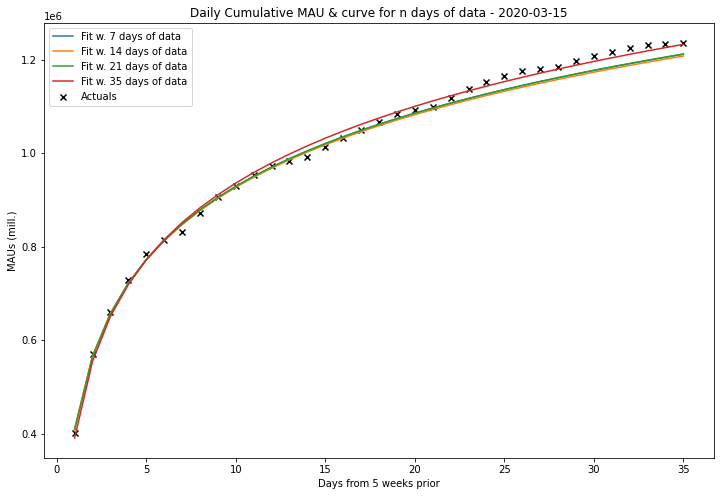

In [47]:
show_cohort("2020-03-15")

[ 2.15184270e+05  4.70937080e+01 -4.11554622e+05]
[ 2.22626898e+05  4.98191289e+01 -4.60456428e+05]
[ 2.35814207e+05  4.28406545e+01 -4.93584016e+05]


/home/jamesarch/environments/project_prophettest/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jamesarch/environments/project_prophettest/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jamesarch/environments/project_prophettest/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jamesarch/environments/project_prophettest/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


[ 2.40540717e+05  4.80605965e+01 -5.46207337e+05]


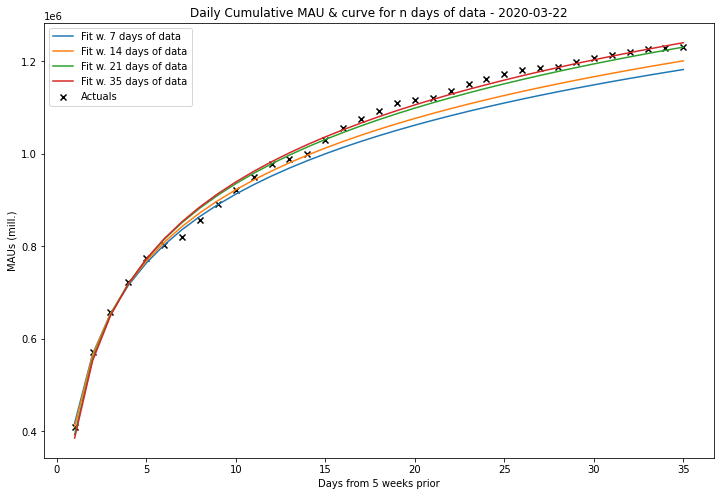

In [48]:
show_cohort("2020-03-22")

/home/jamesarch/environments/project_prophettest/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jamesarch/environments/project_prophettest/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jamesarch/environments/project_prophettest/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jamesarch/environments/project_prophettest/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


[ 2.43068078e+05  3.52514866e+01 -4.87781896e+05]
[ 2.54359590e+05  5.44721206e+01 -6.48611132e+05]
[ 2.52046731e+05  3.44402755e+01 -5.20622884e+05]
[ 2.41483266e+05  5.03981246e+01 -5.57497381e+05]


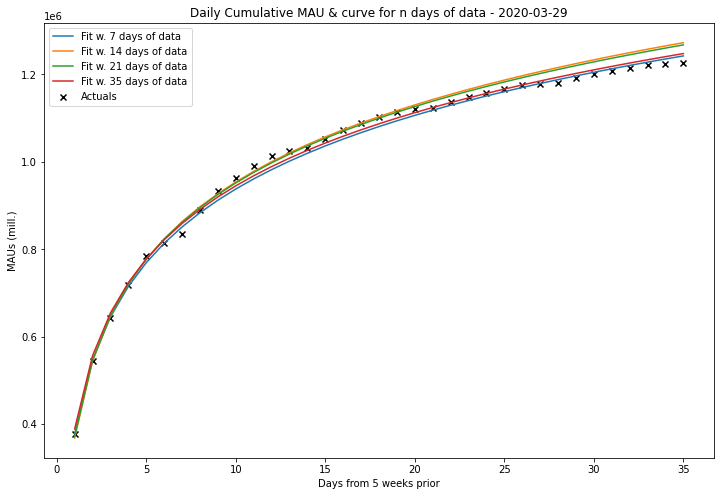

In [49]:
show_cohort("2020-03-29")

/home/jamesarch/environments/project_prophettest/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jamesarch/environments/project_prophettest/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jamesarch/environments/project_prophettest/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


[ 2.23213835e+05  4.38912273e+01 -4.22403577e+05]
[ 2.13867961e+05  5.29220643e+01 -4.18295028e+05]
[ 2.11603962e+05  1.44841253e+02 -6.19472432e+05]
[ 2.20180527e+05  6.80260478e+01 -5.10059379e+05]


/home/jamesarch/environments/project_prophettest/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


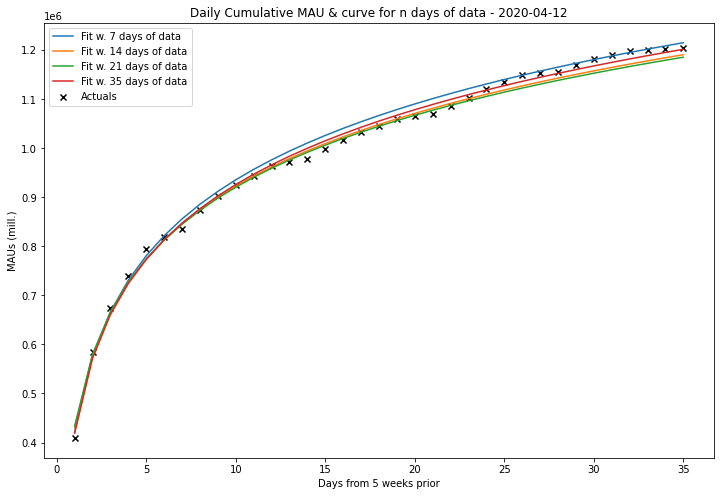

In [50]:
show_cohort("2020-04-12")

/home/jamesarch/environments/project_prophettest/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jamesarch/environments/project_prophettest/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jamesarch/environments/project_prophettest/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jamesarch/environments/project_prophettest/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


[ 2.29507654e+05  1.56370139e+01 -3.38624213e+05]
[ 2.56991664e+05  3.78039100e+01 -6.67198088e+05]
[ 2.63735658e+05  2.76143147e+01 -6.17233326e+05]
[ 2.62781055e+05  6.18915007e+01 -8.24733238e+05]


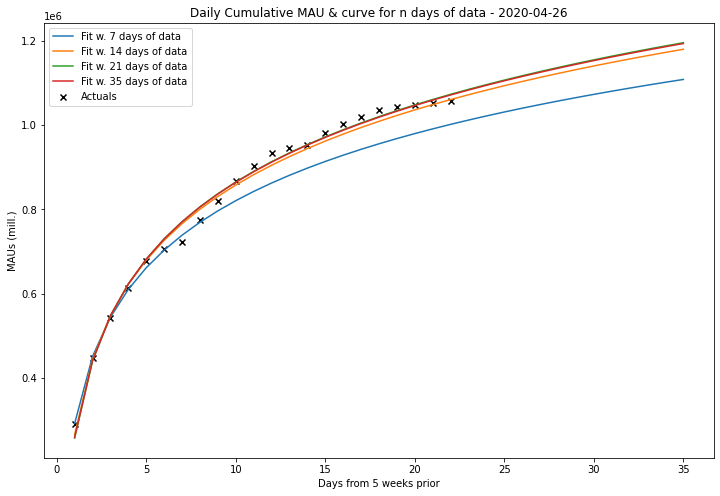

In [51]:
show_cohort("2020-04-26")

In [52]:
df_test.tail()

w_e          dt   n  users  cumul_users     maus
905  2020-03-22  2020-03-18  31   6319      1213228  1231249
906  2020-03-22  2020-03-19  32   6361      1219589  1231249
907  2020-03-22  2020-03-20  33   7152      1226741  1231249
908  2020-03-22  2020-03-21  34   2573      1229314  1231249
909  2020-03-22  2020-03-22  35   1935      1231249  1231249

## Lets use the log curves to fit to past data and project forwards to future weeks

In [53]:
def predict_from_data(df_in, dt_from="2000-01-01", dt_to="2100-01-01"):
    """Take data and plot actuals and logarithmic predctions. Return predictions"""

    df_test = df_in.loc[:][(df_in["w_e"] < dt_to) & (df_in["w_e"] >= dt_from)]
    df_test["n"] = df_test["n"] + 35

    fig = plt.figure(figsize=(12, 8))

    pal = sns.cubehelix_palette(8, start=0.5, rot=-0.75)

    results = {}

    for i, wk in enumerate(df_test["w_e"].unique()):
        df_fit = df_test.loc[:][df_test["w_e"] == wk]

        x_data_fit = df_fit["n"]
        y_data_fit = df_fit["cumul_users"]

        params, params_covariance = optimize.curve_fit(log_func, x_data_fit, y_data_fit)

        x_axis = np.arange(35) + 1

        y_axis = log_func(x_axis, params[0], params[1], params[2])

        if i + 1 == len(df_test["w_e"].unique()):
            marker = "x"
            color = "red"
        else:
            marker = "o"
            color = pal[i]

        plt.scatter(x_data_fit, y_data_fit, label=f"{wk}", color=color, marker=marker)
        plt.plot(x_axis, y_axis, color=color)

        results[wk] = y_axis[34]

    plt.legend(loc="best")
    plt.xlabel("Days from 5 weeks prior")
    plt.ylabel("MAUs")
    plt.title(f"Cumulative MAU curves - from {dt_from} to {dt_to}")

    return results, fig

In [54]:
len(df["w_e"].unique())

34

/home/jamesarch/environments/project_prophettest/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jamesarch/environments/project_prophettest/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jamesarch/environments/project_prophettest/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jamesarch/environments/project_prophettest/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jamesarch/environments/project_prophettest/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufun

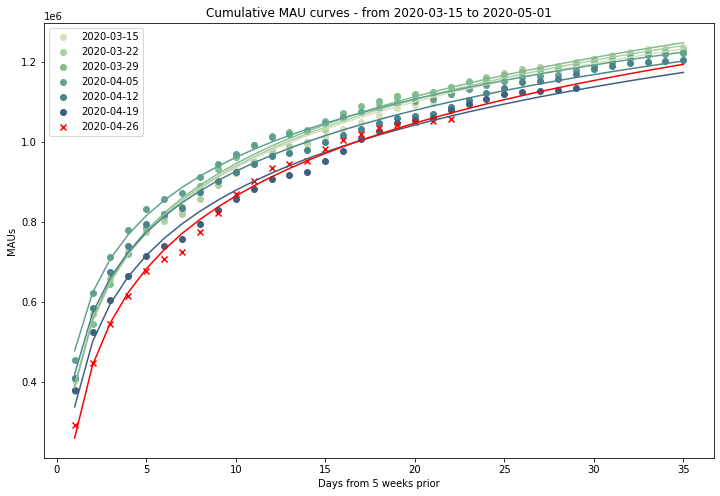

In [55]:
results, fig = predict_from_data(df, "2020-03-15", "2020-05-01")

/home/jamesarch/environments/project_prophettest/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jamesarch/environments/project_prophettest/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jamesarch/environments/project_prophettest/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jamesarch/environments/project_prophettest/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jamesarch/environments/project_prophettest/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufun

TypeError: Improper input: N=3 must not exceed M=1

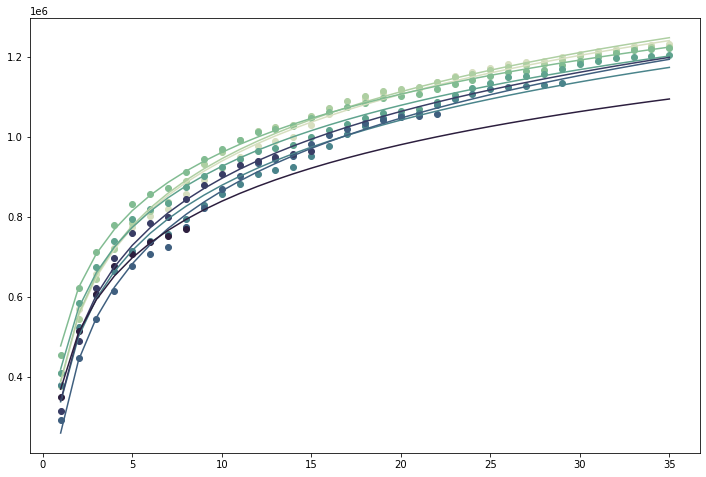

In [61]:
results, fig = predict_from_data(df, "2020-03-22", "2020-06-01")

In [56]:
# Plot the results
df_results = pd.DataFrame(results, index=[0])
df_results = df_results.melt()
df_results.columns = ["week", "maus"]

Text(0.5, 1.0, 'MAU Projection to end of April 2020')

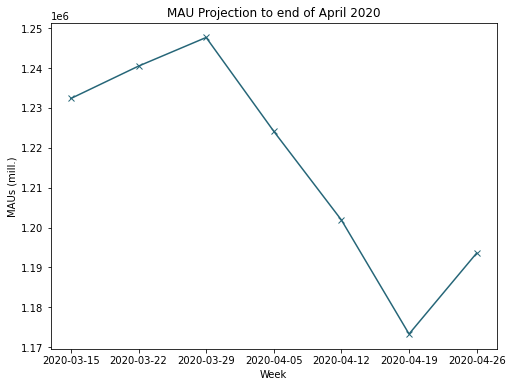

In [57]:
plt.figure(figsize=(8, 6))
plt.plot(df_results["week"], df_results["maus"], marker="x", color="#266678")
plt.xlabel("Week")
plt.ylabel("MAUs (mill.)")
plt.title("MAU Projection to end of April 2020")

In [58]:
df_results

week          maus
0  2020-03-15  1.232363e+06
1  2020-03-22  1.240484e+06
2  2020-03-29  1.247663e+06
3  2020-04-05  1.224136e+06
4  2020-04-12  1.201897e+06
5  2020-04-19  1.173328e+06
6  2020-04-26  1.193617e+06

In [59]:
print(1.247663e06 - 1.173328e06)
print(1.247663e06 - 1.193617e06)
print(1.193617e06 - 1.173328e06)

74335.0
54046.0
20289.0


In [32]:
print(1.247663e06 - 1.152437e06)
print(1.247663e06 - 1.179996e06)
print(1.179996e06 - 1.152437e06)

95226.0
67667.0
27559.0


## What do these curves look like in "normal" times?
.. this should probably be a function

In [33]:
results, fig = predict_from_data(df, "2020-02-02", "2020-03-15")

/home/jamesarch/environments/project_prophettest/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jamesarch/environments/project_prophettest/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jamesarch/environments/project_prophettest/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jamesarch/environments/project_prophettest/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jamesarch/environments/project_prophettest/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufun

/home/jamesarch/environments/project_prophettest/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


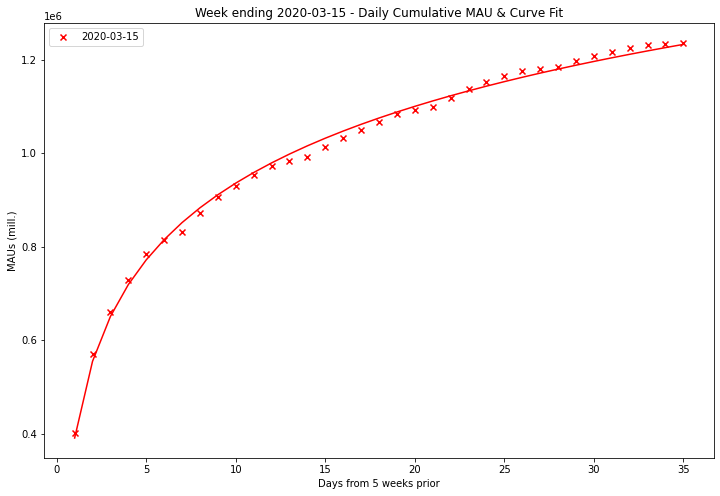

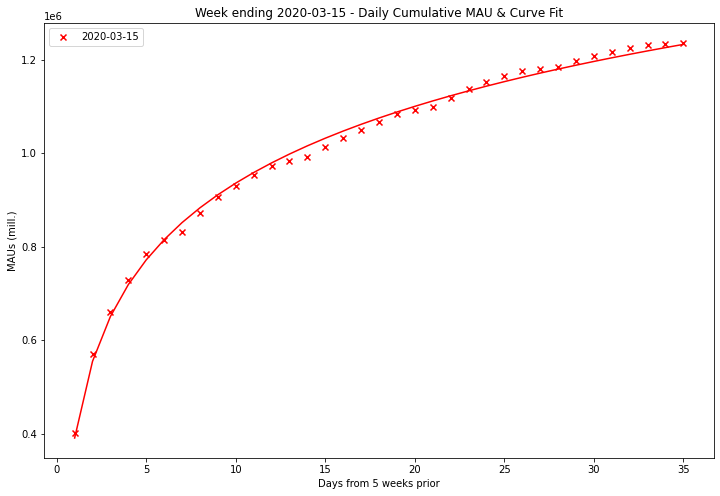

In [34]:
results, fig = predict_from_data(df, "2020-03-14", "2020-03-16")

ax = fig.get_axes()[0]
ax.set(
    ylabel="MAUs (mill.)",
    title="Week ending 2020-03-15 - Daily Cumulative MAU & Curve Fit",
)
# ax.text(20,0.6e6, f'Formula: \n a * log( b * x ) + c \n a = {np.round(params[0])} \n b = {np.round(params[1])} \n c = {np.round(params[2])}',fontsize=12,bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.2))
fig

# Results by Market

In [35]:
def country_results(df, country, dt_from="2000-01-01", dt_to="2100-01-01"):
    """Wrapper for market filtering"""

    df_test = df[df["tnc_country_group"] == country]

    return predict_from_data(df_test, dt_from, dt_to)

In [36]:
"""Query
with first_in_period as (
	select w.start_time::date as wk,
			w.end_time::date as w_e,
			z.user_created,
			tnc_country_group,
			min(txn_ts::date) as min_txn
	from dwh_cohort_weeks as w
	inner join dbt.zrh_transactions as z
	on z.txn_ts between  w.end_time - interval '35 days' and w.end_time 
	and activity_incl_flg is true
	inner join dbt.zrh_users as u
	on u.user_created = z.user_created
	and country_tnc_legal != 'GBR'
	where w.end_time <= current_date + interval '42_days'
	and w.end_time >= current_date - interval '200 days'
	group by 1,2,3,4)
, users_agg as ( 	
	select p.w_e,
		   p.min_txn as dt,
		   tnc_country_group,
		   count(*) as users
	from first_in_period as p
	group by 1,2,3)
select  tnc_country_group,
		w_e,
		dt,
		datediff('day',w_e,dt) as n,
		coalesce(users,0) as users,
	    sum(a.users) over (partition by w_e,tnc_country_group order by dt rows unbounded preceding) as cumul_users,
	    sum(a.users) over (partition by w_e,tnc_country_group) as maus
from users_agg as a
order by 1,2
"""
df_c = pd.read_csv("country_cumul_mau_202004141938.csv")

In [37]:
df_c["tnc_country_group"] = df_c["tnc_country_group"].str.strip()
df_c = df_c[df_c["tnc_country_group"] != "GBR"]

/home/jamesarch/environments/project_prophettest/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jamesarch/environments/project_prophettest/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jamesarch/environments/project_prophettest/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jamesarch/environments/project_prophettest/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jamesarch/environments/project_prophettest/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufun

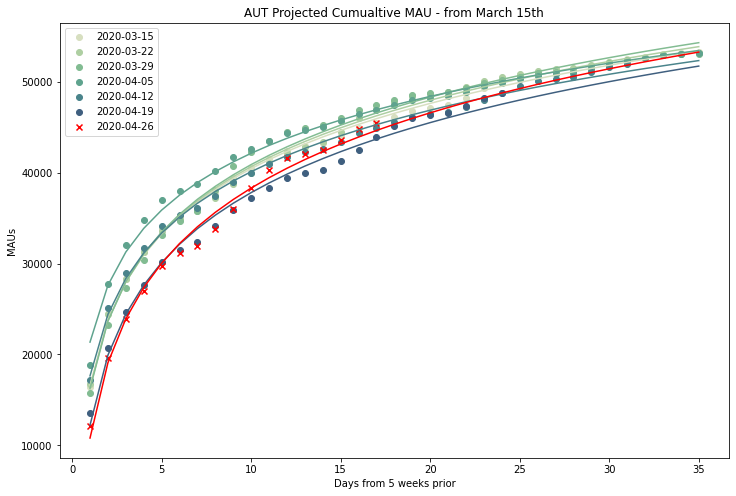

/home/jamesarch/environments/project_prophettest/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jamesarch/environments/project_prophettest/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jamesarch/environments/project_prophettest/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jamesarch/environments/project_prophettest/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jamesarch/environments/project_prophettest/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufun

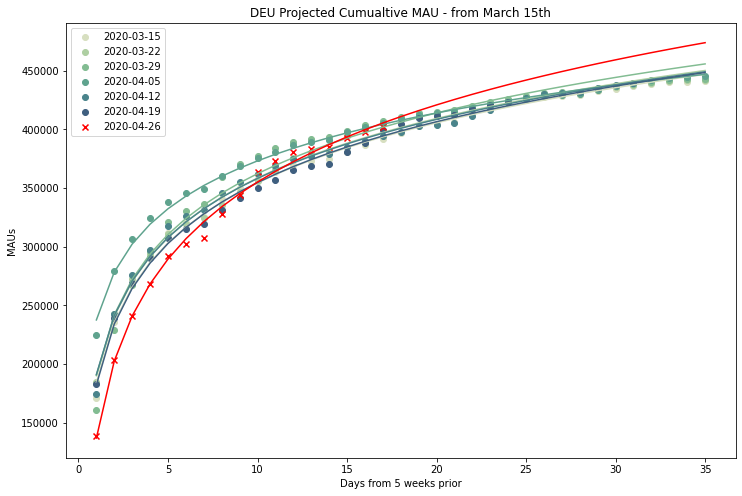

/home/jamesarch/environments/project_prophettest/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jamesarch/environments/project_prophettest/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jamesarch/environments/project_prophettest/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jamesarch/environments/project_prophettest/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jamesarch/environments/project_prophettest/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufun

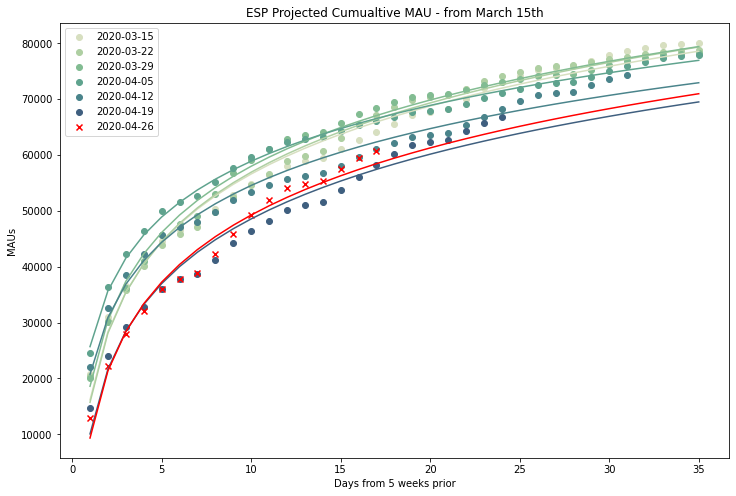

/home/jamesarch/environments/project_prophettest/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jamesarch/environments/project_prophettest/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jamesarch/environments/project_prophettest/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jamesarch/environments/project_prophettest/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jamesarch/environments/project_prophettest/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufun

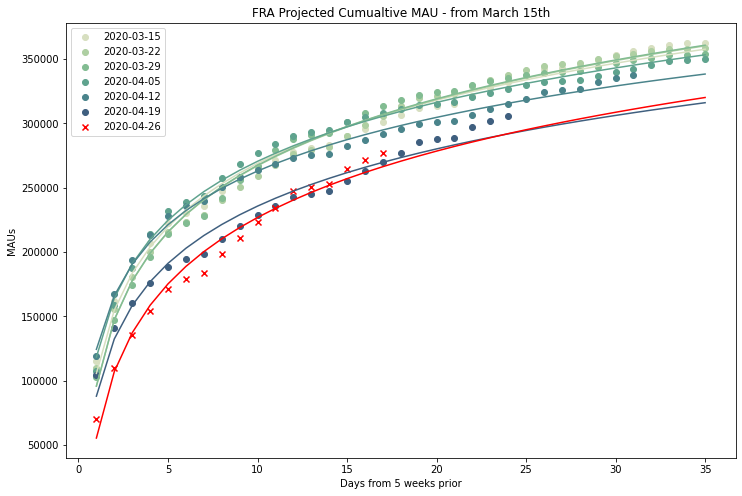

/home/jamesarch/environments/project_prophettest/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jamesarch/environments/project_prophettest/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jamesarch/environments/project_prophettest/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jamesarch/environments/project_prophettest/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jamesarch/environments/project_prophettest/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufun

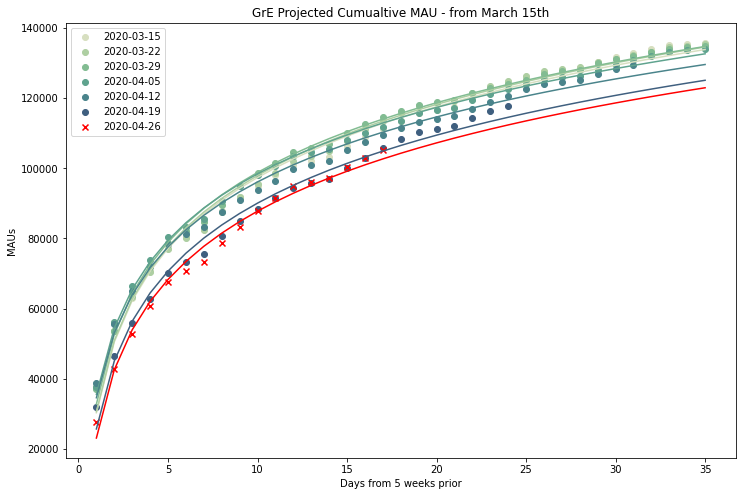

/home/jamesarch/environments/project_prophettest/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jamesarch/environments/project_prophettest/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jamesarch/environments/project_prophettest/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jamesarch/environments/project_prophettest/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jamesarch/environments/project_prophettest/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufun

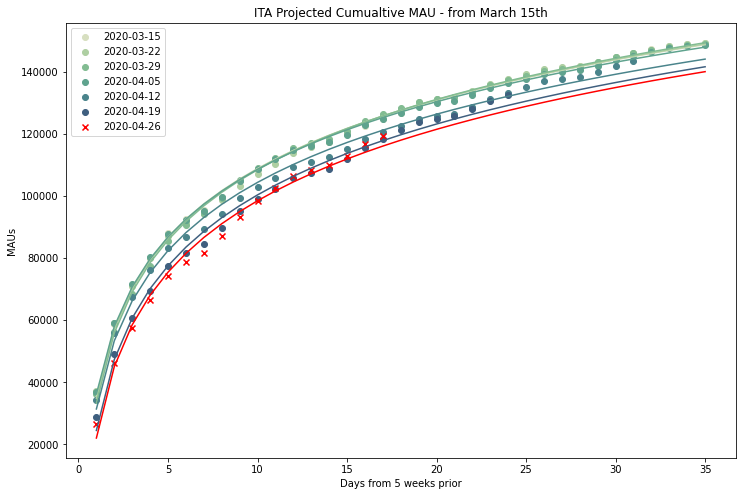

/home/jamesarch/environments/project_prophettest/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jamesarch/environments/project_prophettest/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jamesarch/environments/project_prophettest/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jamesarch/environments/project_prophettest/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jamesarch/environments/project_prophettest/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufun

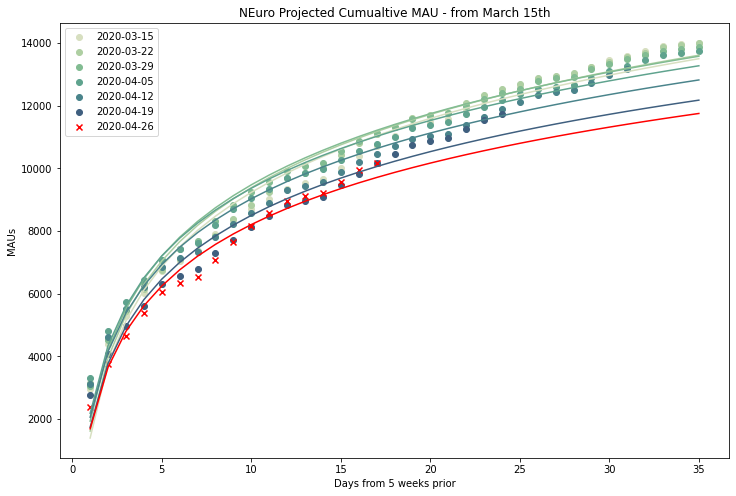

In [38]:
results_c = {}
for c in df_c["tnc_country_group"].unique():
    res, fig = country_results(df_c, c, "2020-03-15", "2020-05-01")
    #     plt.title(f"{c} Projected Cumualtive MAU - from March 15th")
    results_c[c] = res
    ax = fig.get_axes()[0]
    ax.set(title=f"{c} Projected Cumualtive MAU - from March 15th")
    plt.show()

In [30]:
df_results = pd.DataFrame(results_c)

In [31]:
df_results.reset_index(inplace=True)

In [32]:
df_results.head()

index           AUT            DEU           ESP            FRA  \
0  2020-03-15  53398.645577  446731.726509  78591.461457  357652.720678   
1  2020-03-22  53850.771146  450040.452229  79334.516572  360246.315327   
2  2020-03-29  54286.717245  455636.365155  79415.022046  360761.279192   
3  2020-04-05  53413.970869  446685.786041  76906.366400  353206.198528   
4  2020-04-12  52110.036254  448569.366341  72254.004762  336619.963941   

             GrE            ITA         NEuro  
0  133801.609687  148691.312751  13495.077971  
1  134513.475290  148892.062107  13605.855268  
2  134675.389008  149314.638652  13573.476808  
3  132524.011281  147843.229765  13257.374628  
4  128773.270968  143306.375136  12661.103468

In [33]:
df_results = df_results.melt(id_vars="index")

In [34]:
df_results.head()

index variable         value
0  2020-03-15      AUT  53398.645577
1  2020-03-22      AUT  53850.771146
2  2020-03-29      AUT  54286.717245
3  2020-04-05      AUT  53413.970869
4  2020-04-12      AUT  52110.036254

In [35]:
df_results.columns = ["week", "country", "maus"]

In [36]:
df_results["maus_uk_adj"] = np.where(
    (df_results["country"] == "GBR") & (df_results["week"] >= "2020-04-15"),
    0,
    df_results["maus"],
)

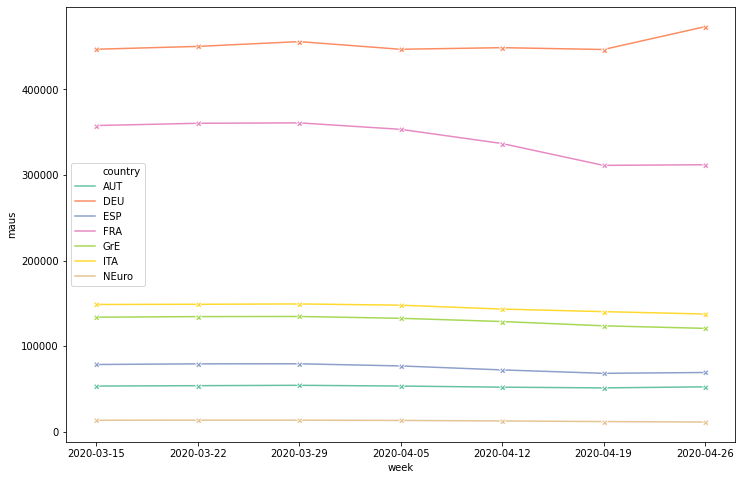

In [37]:
plt.figure(figsize=(12, 8))
sns.lineplot(
    data=df_results, x="week", y="maus", hue="country", marker="X", palette="Set2"
)

Text(0.5, 1.0, 'MAU Projection to end of April 2020 - adjusted for UK closure')

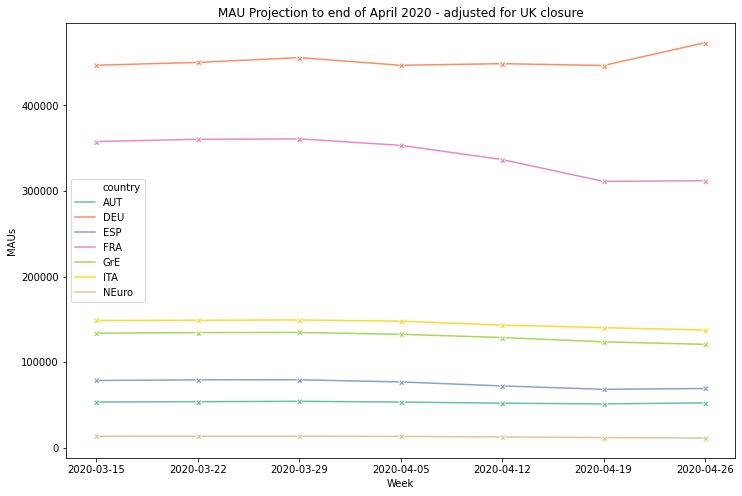

In [38]:
plt.figure(figsize=(12, 8))
sns.lineplot(
    data=df_results,
    x="week",
    y="maus_uk_adj",
    hue="country",
    marker="X",
    palette="Set2",
)
plt.xlabel("Week")
plt.ylabel("MAUs")
plt.legend()
plt.title("MAU Projection to end of April 2020 - adjusted for UK closure")

Text(0.5, 1.0, 'MAU Projection to end of April 2020')

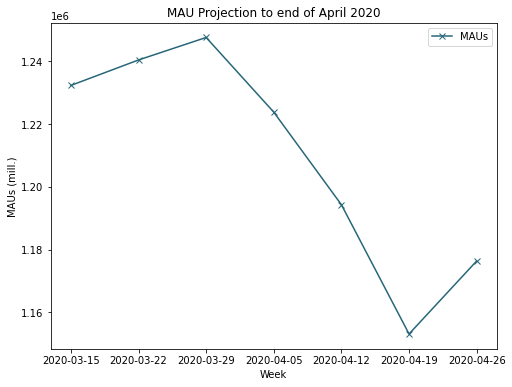

In [39]:
df_g = df_results.groupby(["week"])[["maus", "maus_uk_adj"]].sum().reset_index()
plt.figure(figsize=(8, 6))
# plt.plot(df_g['week'],df_g['maus_uk_adj'],marker='x',color='#28ac8d',label='MAUs adj. UK closure')
plt.plot(df_g["week"], df_g["maus"], marker="x", color="#266678", label="MAUs")
plt.xlabel("Week")
plt.ylabel("MAUs (mill.)")
plt.legend()
plt.title("MAU Projection to end of April 2020")

In [40]:
df_g

week          maus   maus_uk_adj
0  2020-03-15  1.232363e+06  1.232363e+06
1  2020-03-22  1.240483e+06  1.240483e+06
2  2020-03-29  1.247663e+06  1.247663e+06
3  2020-04-05  1.223837e+06  1.223837e+06
4  2020-04-12  1.194294e+06  1.194294e+06
5  2020-04-19  1.153067e+06  1.153067e+06
6  2020-04-26  1.176354e+06  1.176354e+06

In [42]:
df_l = df_results[df_results["week"] == "2020-03-29"]
df_r = df_results[df_results["week"] == "2020-04-26"]
df_merge = pd.merge(df_l, df_r, how="inner", on="country")

In [43]:
df_merge.head()

week_x country         maus_x  maus_uk_adj_x      week_y  \
0  2020-03-29     AUT   54286.717245   54286.717245  2020-04-26   
1  2020-03-29     DEU  455636.365155  455636.365155  2020-04-26   
2  2020-03-29     ESP   79415.022046   79415.022046  2020-04-26   
3  2020-03-29     FRA  360761.279192  360761.279192  2020-04-26   
4  2020-03-29     GrE  134675.389008  134675.389008  2020-04-26   

          maus_y  maus_uk_adj_y  
0   52494.252242   52494.252242  
1  473065.947453  473065.947453  
2   69237.881385   69237.881385  
3  311862.313247  311862.313247  
4  120777.562546  120777.562546

In [44]:
df_merge["mau_change"] = df_merge["maus_y"] - df_merge["maus_x"]
df_merge["mau_change_perc"] = (
    (df_merge["maus_y"] - df_merge["maus_x"]) / df_merge["maus_x"] * 100
)
# df_merge['mau_change_uk_adj'] = df_merge['maus_uk_adj_y'] - df_merge['maus_uk_adj_x']
# df_merge['mau_change_uk_adj_perc'] = (df_merge['maus_uk_adj_y'] - df_merge['maus_uk_adj_x'] )/ df_merge['maus_uk_adj_x'] * 100

Text(0.5, 1.0, 'Change in MAU from 2020-03-29 to 2020-04-26')

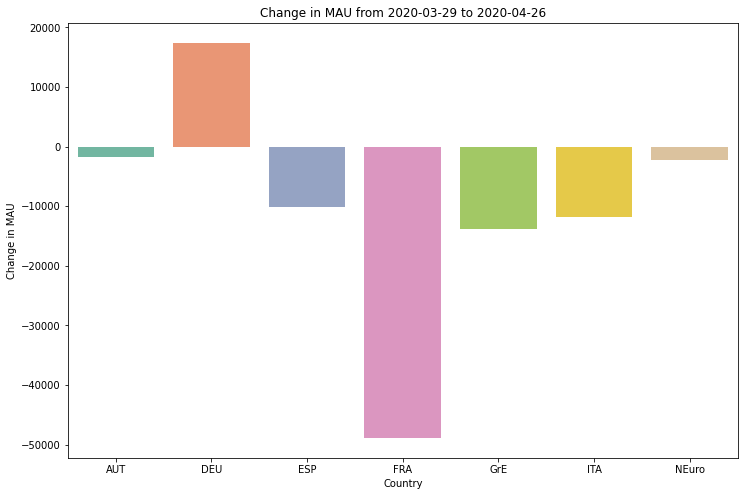

In [45]:
plt.figure(figsize=(12, 8))
sns.barplot(data=df_merge, x="country", y="mau_change", palette="Set2")
plt.xlabel("Country")
plt.ylabel("Change in MAU")
plt.title("Change in MAU from 2020-03-29 to 2020-04-26")

In [46]:
df_merge

week_x country         maus_x  maus_uk_adj_x      week_y  \
0  2020-03-29     AUT   54286.717245   54286.717245  2020-04-26   
1  2020-03-29     DEU  455636.365155  455636.365155  2020-04-26   
2  2020-03-29     ESP   79415.022046   79415.022046  2020-04-26   
3  2020-03-29     FRA  360761.279192  360761.279192  2020-04-26   
4  2020-03-29     GrE  134675.389008  134675.389008  2020-04-26   
5  2020-03-29     ITA  149314.638652  149314.638652  2020-04-26   
6  2020-03-29   NEuro   13573.476808   13573.476808  2020-04-26   

          maus_y  maus_uk_adj_y    mau_change  mau_change_perc  
0   52494.252242   52494.252242  -1792.465003        -3.301848  
1  473065.947453  473065.947453  17429.582298         3.825327  
2   69237.881385   69237.881385 -10177.140661       -12.815133  
3  311862.313247  311862.313247 -48898.965944       -13.554383  
4  120777.562546  120777.562546 -13897.826462       -10.319500  
5  137524.155664  137524.155664 -11790.482987        -7.896401  
6   11391.666787   11391.666787  -2181.810021       -16.074069

Text(0.5, 1.0, '% Change in MAU from 2020-03-29 to 2020-04-26')

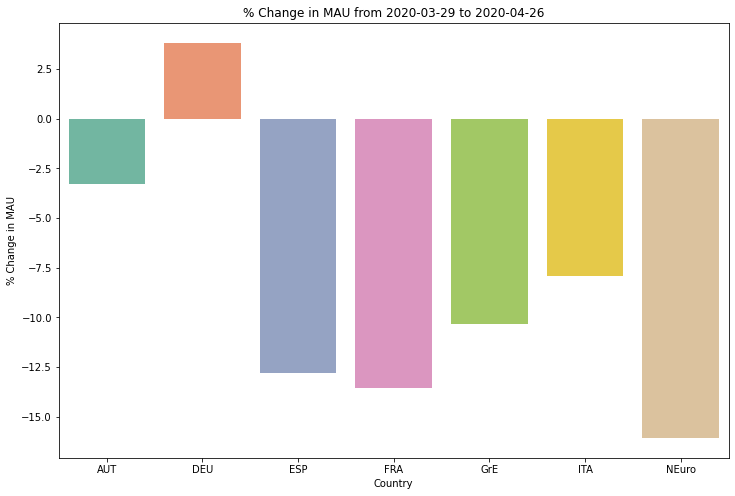

In [47]:
plt.figure(figsize=(12, 8))
sns.barplot(data=df_merge, x="country", y="mau_change_perc", palette="Set2")
plt.xlabel("Country")
plt.ylabel("% Change in MAU")
plt.title("% Change in MAU from 2020-03-29 to 2020-04-26")

In [48]:
np.arange(35) + 1

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35])

# How are different user segments affected?

In [53]:
"""Query
with first_in_period as (
	select w.start_time::date as wk,
			w.end_time::date as w_e,
			z.user_created,
			uc.cluster_new as user_cluster,
			min(txn_ts::date) as min_txn
	from dwh_cohort_weeks as w
	inner join dbt.zrh_transactions as z
	on z.txn_ts between  w.end_time - interval '35 days' and w.end_time 
	and z.txn_ts < current_date
	and activity_incl_flg is true
	inner join dbt.zrh_users as u
	on u.user_created = z.user_created
	and country_tnc_legal != 'GBR'
	inner join dev_dbt.user_clusters_mapping as ucm
	on ucm.user_id = u.user_id 
	inner join dev_dbt.user_clusters as uc
	on uc.id = ucm.id
	where w.end_time <= current_date + interval '42_days'
	and w.end_time >= current_date - interval '200 days'
	group by 1,2,3,4)
, users_agg as (	
	select w_e,
		   min_txn as dt,
		   user_cluster,
		   count(*) as users
	from first_in_period as p
	group by 1,2,3)
, spine as (
	select w.end_time::date as w_e,
		   d.start_time as dt,
		   user_cluster
	from dwh_cohort_weeks as w
	inner join dwh_cohort_dates as d
	on d.end_time between w.end_time - interval '34 days' and w.end_time 
	cross join (select distinct cluster_new as user_cluster from dev_dbt.user_clusters) as a
    where w.end_time <= current_date + interval '42_days'
	and w.end_time >= current_date - interval '200 days')
select  s.user_cluster,
		s.w_e,
		s.dt,
		datediff('day',s.w_e,s.dt) as n,
		coalesce(a.users,0) as users,
	    sum(a.users) over (partition by s.w_e,s.user_cluster order by s.dt rows unbounded preceding) as cumul_users,
	    sum(a.users) over (partition by s.w_e,s.user_cluster) as maus
from spine as s
left join users_agg as a
on s.user_cluster = a.user_cluster
and s.dt = a.dt
and s.w_e = a.w_e
order by 1,2"""
df_uc = pd.read_csv("cumul_clusters_maus_exclUK_202004061047.csv")

In [54]:
df_uc["n"] = df_uc["n"] + 35
df_uc.head()

user_cluster         w_e                   dt  n  users  cumul_users  \
0             1  2019-09-22  2019-08-19 00:00:00  1   1108       1108.0   
1             1  2019-09-22  2019-08-20 00:00:00  2    351       1459.0   
2             1  2019-09-22  2019-08-21 00:00:00  3    152       1611.0   
3             1  2019-09-22  2019-08-22 00:00:00  4     87       1698.0   
4             1  2019-09-22  2019-08-23 00:00:00  5     67       1765.0   

     maus  
0  2075.0  
1  2075.0  
2  2075.0  
3  2075.0  
4  2075.0

In [55]:
dict_cluster_mapping = {
    1: "Primary Account",
    2: "Spaces Power Users",
    3: "Secondary Spender",
    4: "International Travelers",
    5: "EuroTravelers",
    6: "Cash26 ers",
    7: "Unconvinced",
    8: "Holding Account",
    9: "Barely Active",
    10: "Referral & Run",
}
df_uc["cluser_str"] = df_uc["user_cluster"].map(dict_cluster_mapping)

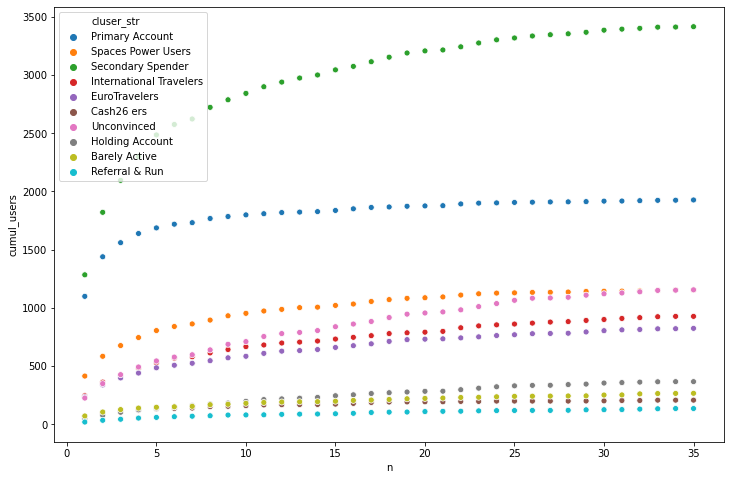

In [56]:
df_p = df_uc[df_uc["w_e"] == "2020-03-15"]
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_p, x="n", y="cumul_users", hue="cluser_str", legend="full")

In [57]:
df_p["user_cluster"].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [62]:
def plot_cluster(df, field, cluster, start, end, project=False):
    df_test = df[df[field] == cluster]
    df_test = df_test[(df_test["w_e"] < end) & (df_test["w_e"] >= start)]

    plt.figure(figsize=(12, 8))

    pal = sns.cubehelix_palette(12, start=0.5, rot=-0.75)

    results = {}

    for i, wk in enumerate(df_test["w_e"].unique()):
        df_fit = df_test[df_test["w_e"] == wk]

        x_data_fit = df_fit["n"]
        y_data_fit = df_fit["cumul_users"]

        x_axis = np.arange(35) + 1

        if project:
            plt.scatter(x_data_fit, y_data_fit, label=f"{wk}", color=pal[i])

            params, params_covariance = optimize.curve_fit(
                log_func, x_data_fit, y_data_fit
            )

            y_axis = log_func(x_axis, params[0], params[1], params[2])

            plt.plot(x_axis, y_axis, color=pal[i])

            results[wk] = y_axis[34]

        else:
            plt.plot(x_data_fit, y_data_fit, label=f"{wk}", color=pal[i], marker="x")

    plt.legend(loc="best")
    plt.xlabel("Days from 5 weeks prior")
    plt.ylabel("MAUs")
    plt.title(f"{cluster} Cluster - MAU Trends")

    plt.show()

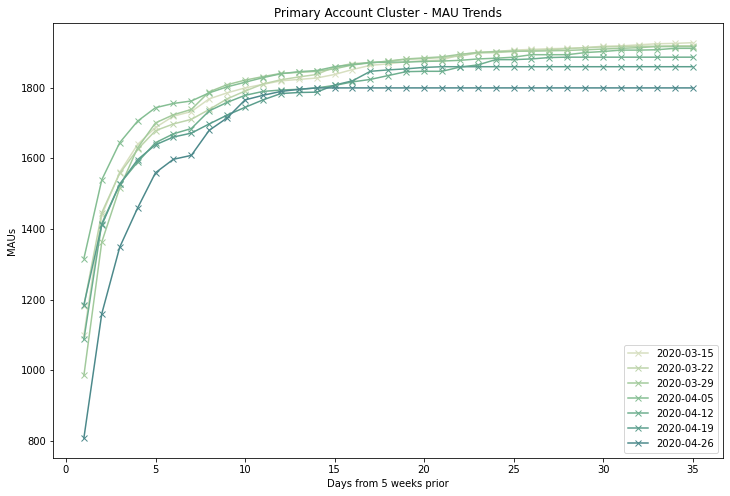

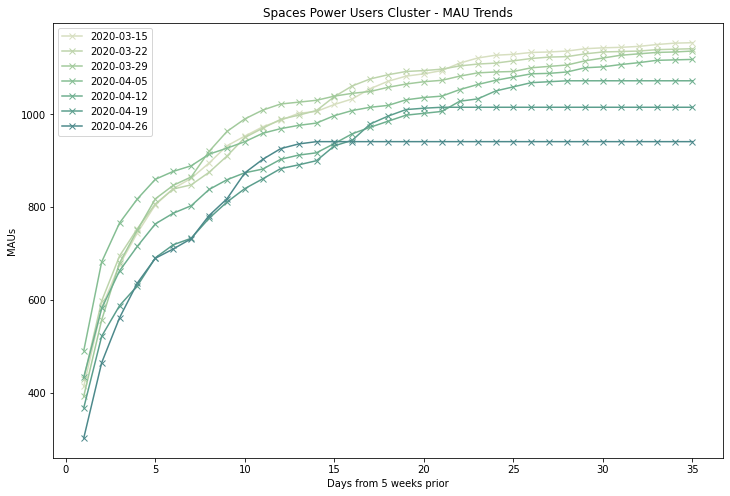

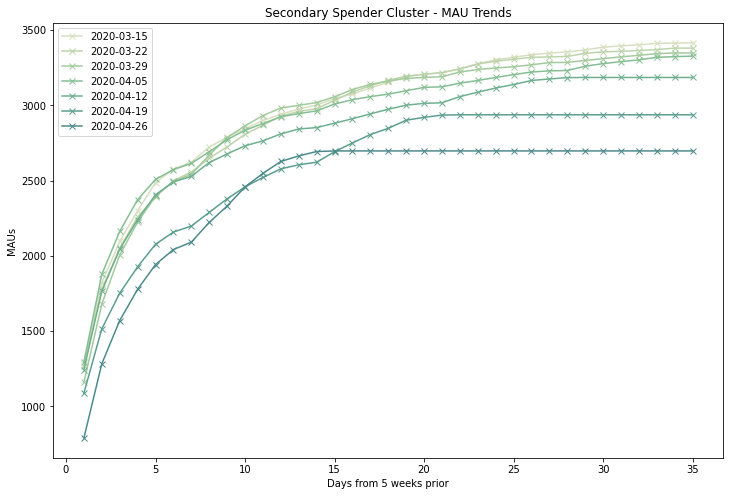

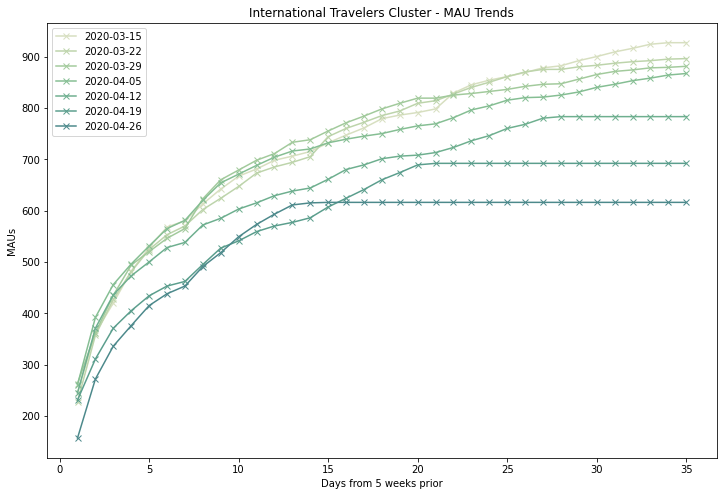

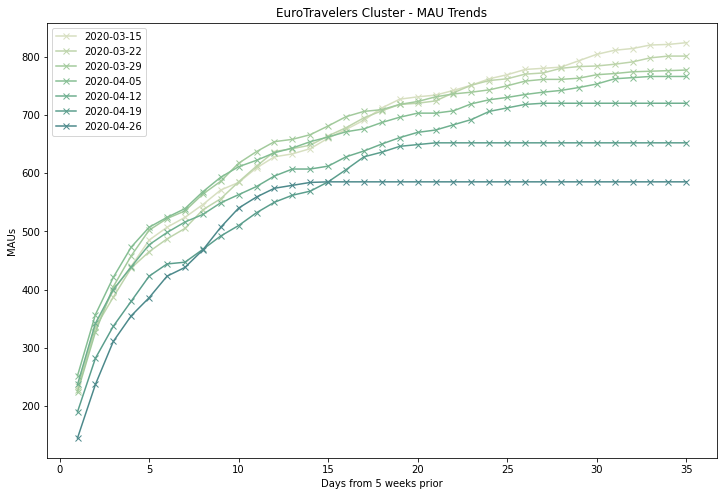

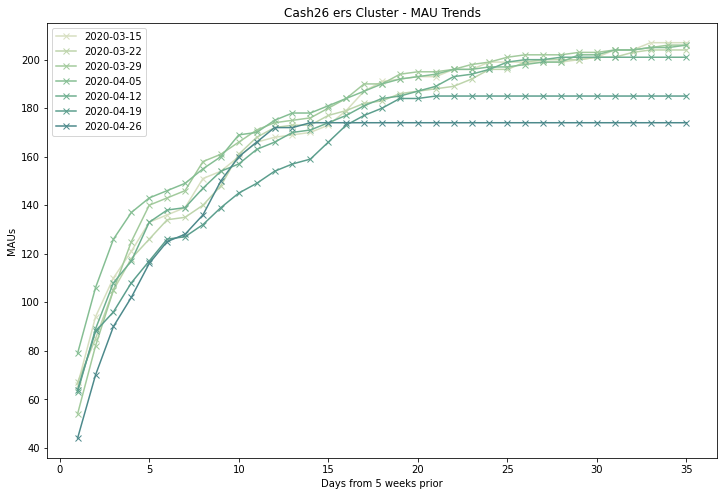

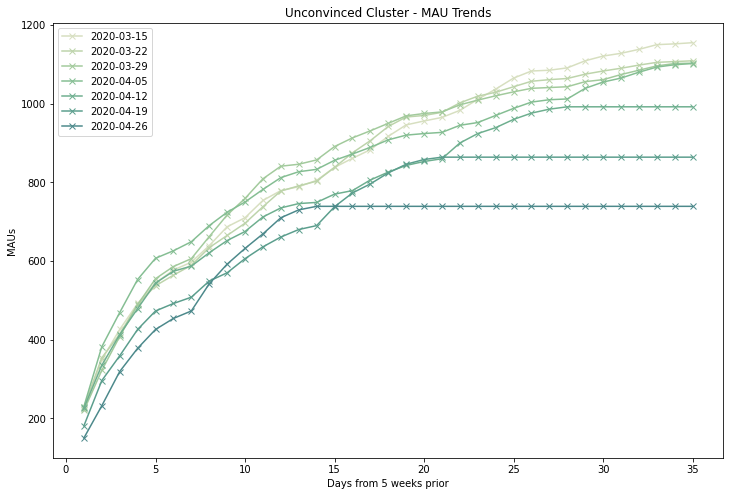

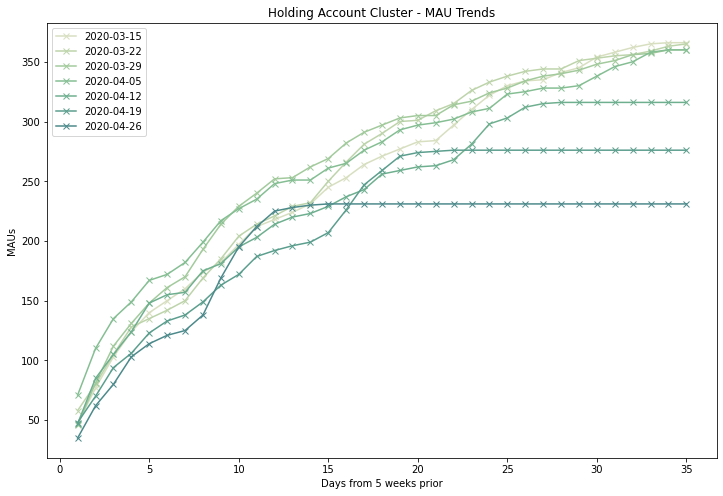

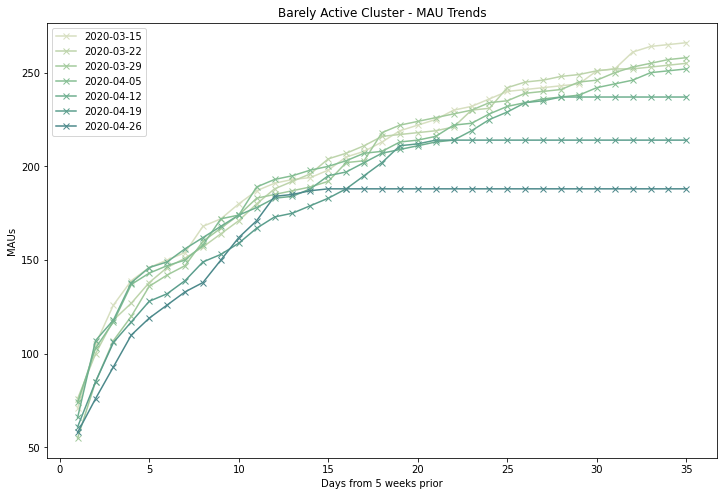

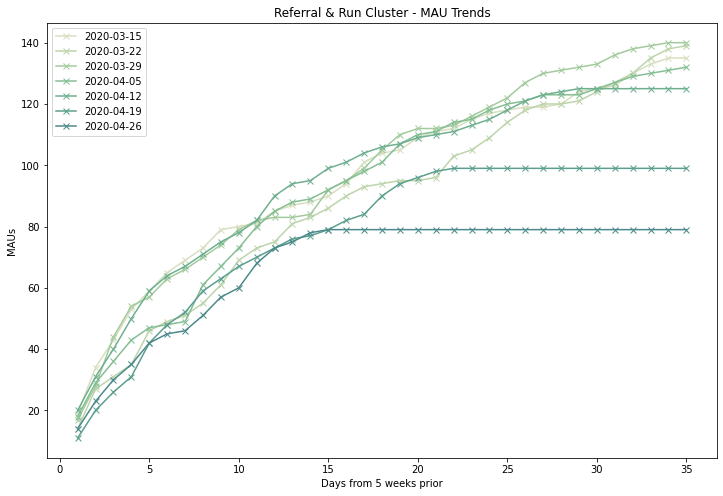

In [59]:
for c in df_uc["cluser_str"].unique():
    plot_cluster(df_uc, "cluser_str", c, "2020-03-15", "2020-04-29")

In [65]:
df_dau = pd.read_csv("daus_clusters_202004012341.csv")
df_dau["act_date"] = pd.to_datetime(df_dau["act_date"])
df_dau["cluser_str"] = df_dau["user_cluster"].map(dict_cluster_mapping)

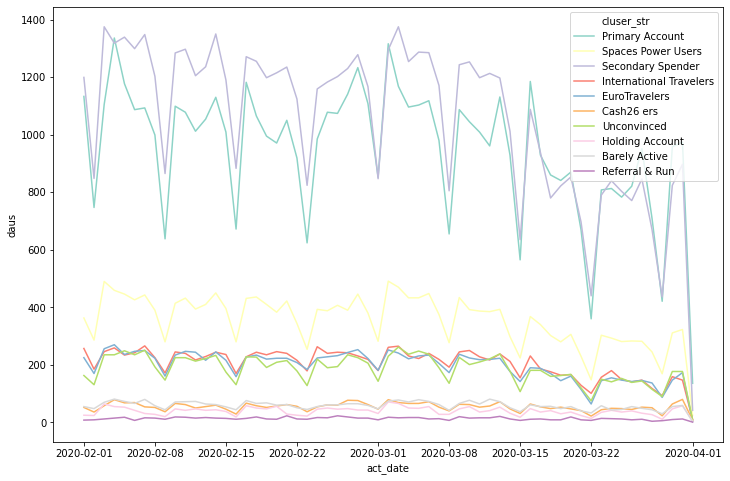

In [66]:
plt.figure(figsize=(12, 8))
sns.lineplot(data=df_dau, x="act_date", y="daus", hue="cluser_str", palette="Set3")

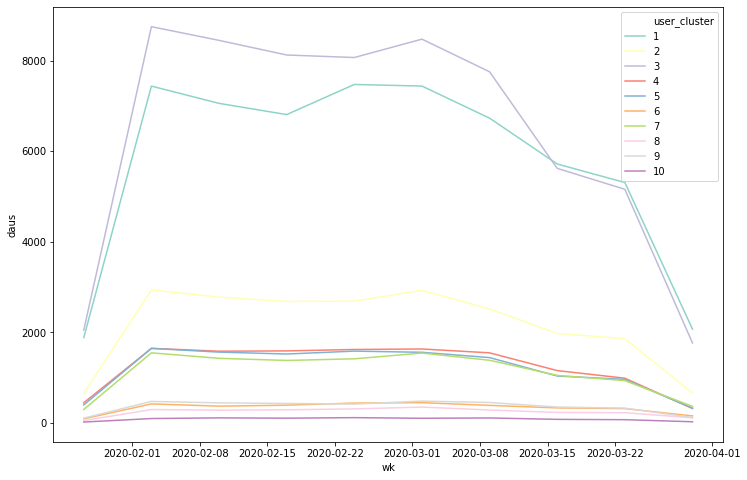

In [67]:
df_wau = pd.read_csv("waus_clusters_202004012346.csv")
df_wau["wk"] = pd.to_datetime(df_wau["wk"])

plt.figure(figsize=(12, 8))
sns.lineplot(data=df_wau, x="wk", y="daus", hue="user_cluster", palette="Set3")

In [68]:
df_dau["moving"] = df_dau.groupby("user_cluster")["daus"].transform(
    lambda x: x.rolling(7, 1).mean()
)

In [69]:
df_dau

act_date  user_cluster  daus               cluser_str       moving
0   2020-02-01             1  1133          Primary Account  1133.000000
1   2020-02-01             2   363       Spaces Power Users   363.000000
2   2020-02-01             3  1199        Secondary Spender  1199.000000
3   2020-02-01             4   257  International Travelers   257.000000
4   2020-02-01             5   225            EuroTravelers   225.000000
..         ...           ...   ...                      ...          ...
605 2020-04-01             6     8               Cash26 ers    46.285714
606 2020-04-01             7     9              Unconvinced   121.571429
607 2020-04-01             8     5          Holding Account    31.428571
608 2020-04-01             9     2            Barely Active    42.000000
609 2020-04-01            10     1           Referral & Run     7.571429

[610 rows x 5 columns]

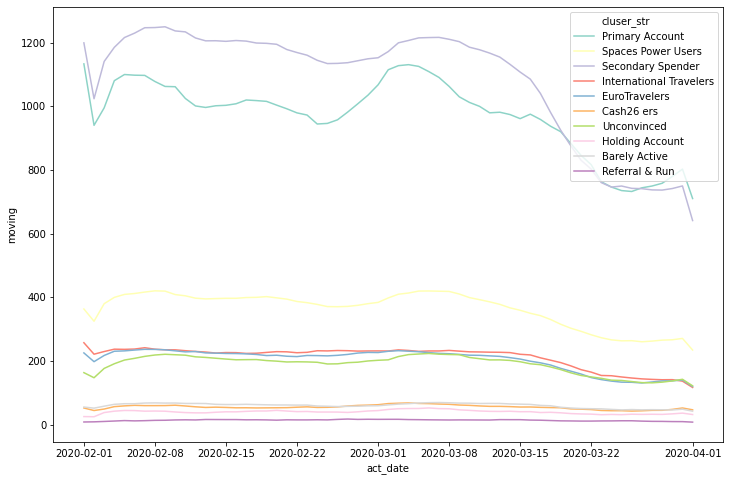

In [70]:
plt.figure(figsize=(12, 8))
sns.lineplot(data=df_dau, x="act_date", y="moving", hue="cluser_str", palette="Set3")

In [71]:
df_dau["daus_max"] = df_dau.groupby(["user_cluster"])["daus"].transform(max)

In [72]:
df_dau["rel_daus"] = df_dau["daus"] / df_dau["daus_max"] * 100

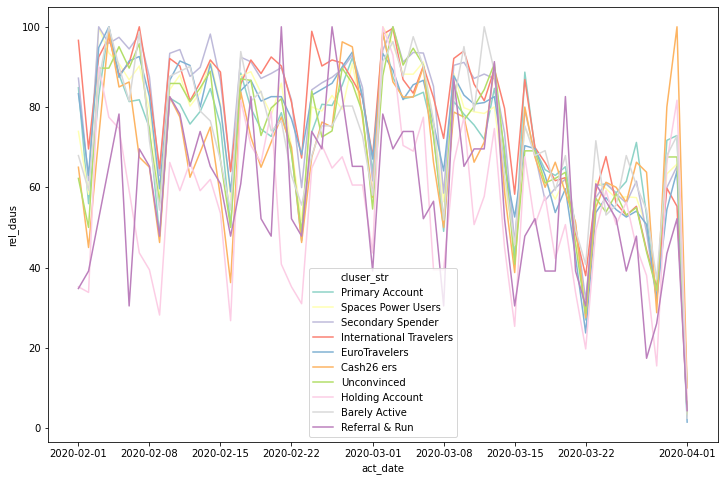

In [73]:
plt.figure(figsize=(12, 8))
sns.lineplot(data=df_dau, x="act_date", y="rel_daus", hue="cluser_str", palette="Set3")

In [74]:
df_dau["moving_rel"] = df_dau.groupby("user_cluster")["rel_daus"].transform(
    lambda x: x.rolling(7, 1).mean()
)

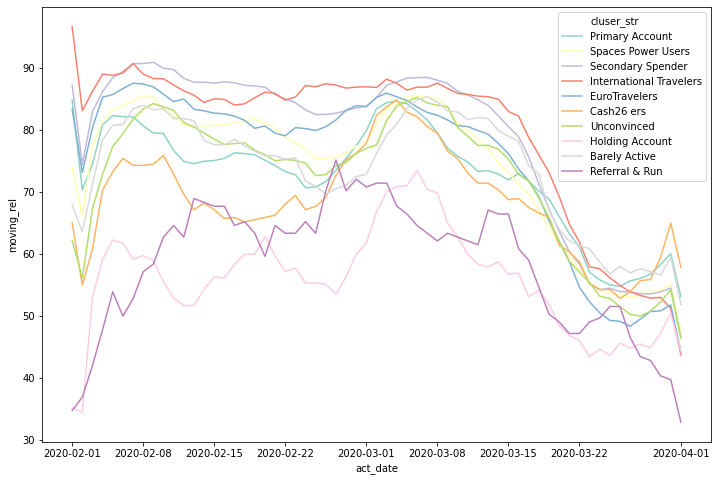

In [75]:
plt.figure(figsize=(12, 8))
sns.lineplot(
    data=df_dau, x="act_date", y="moving_rel", hue="cluser_str", palette="Set3"
)

In [76]:
df_dau[df_dau["user_cluster"] == 10]

act_date  user_cluster  daus      cluser_str     moving  daus_max  \
9   2020-02-01            10     8  Referral & Run   8.000000        23   
19  2020-02-02            10     9  Referral & Run   8.500000        23   
29  2020-02-03            10    12  Referral & Run   9.666667        23   
39  2020-02-04            10    15  Referral & Run  11.000000        23   
49  2020-02-05            10    18  Referral & Run  12.400000        23   
..         ...           ...   ...             ...        ...       ...   
569 2020-03-28            10     4  Referral & Run  10.000000        23   
579 2020-03-29            10     6  Referral & Run   9.857143        23   
589 2020-03-30            10    10  Referral & Run   9.285714        23   
599 2020-03-31            10    12  Referral & Run   9.142857        23   
609 2020-04-01            10     1  Referral & Run   7.571429        23   

      rel_daus  moving_rel  
9    34.782609   34.782609  
19   39.130435   36.956522  
29   52.173913   42.028986  
39   65.217391   47.826087  
49   78.260870   53.913043  
..         ...         ...  
569  17.391304   43.478261  
579  26.086957   42.857143  
589  43.478261   40.372671  
599  52.173913   39.751553  
609   4.347826   32.919255  

[61 rows x 8 columns]

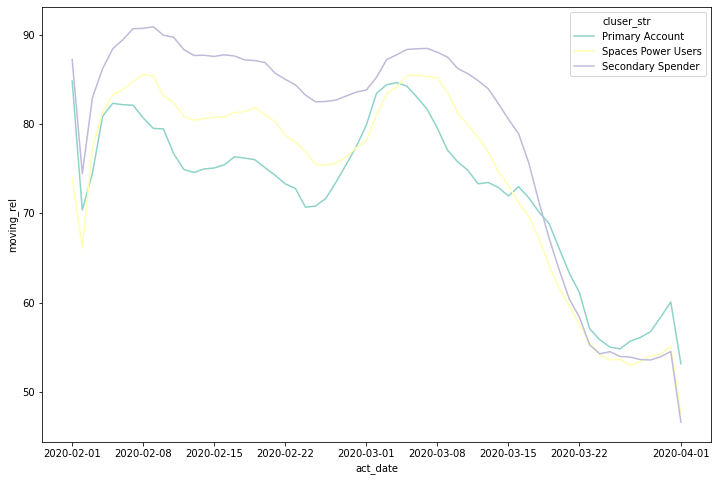

In [77]:
plt.figure(figsize=(12, 8))
df_p = df_dau[df_dau["user_cluster"].isin([1, 2, 3])]
sns.lineplot(data=df_p, x="act_date", y="moving_rel", hue="cluser_str", palette="Set3")

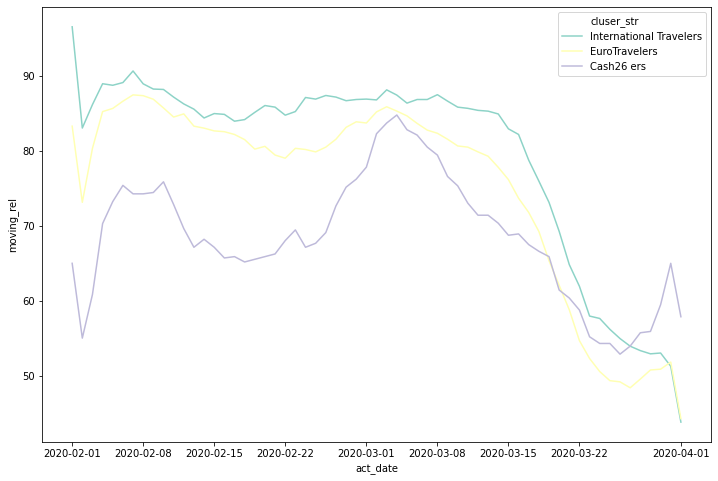

In [78]:
plt.figure(figsize=(12, 8))
df_p = df_dau[df_dau["user_cluster"].isin([4, 5, 6])]
sns.lineplot(data=df_p, x="act_date", y="moving_rel", hue="cluser_str", palette="Set3")

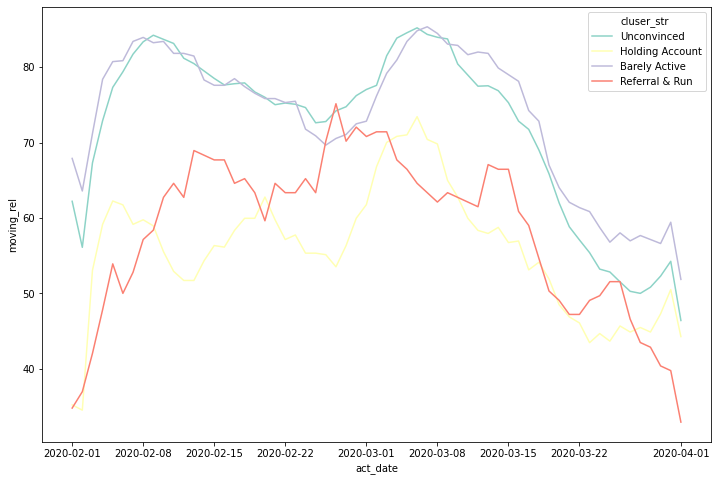

In [79]:
plt.figure(figsize=(12, 8))
df_p = df_dau[df_dau["user_cluster"].isin([7, 8, 9, 10])]
sns.lineplot(data=df_p, x="act_date", y="moving_rel", hue="cluser_str", palette="Set3")

# How are different activity levels affected?

In [80]:
"""
with first_in_period as (
	select w.start_time::date as wk,
			w.end_time::date as w_e,
			z.user_created,
			count(z.txn_id) as n_txns,
			min(txn_ts::date) as min_txn
	from dwh_cohort_weeks as w
	inner join dbt.zrh_transactions as z
	on z.txn_ts between  w.end_time - interval '35 days' and w.end_time 
	and activity_incl_flg is true
	inner join dbt.zrh_users as u
	on u.user_created = z.user_created
	and country_tnc_legal != 'GBR'
	where w.end_time <= current_date + interval '42_days'
	and w.end_time >= current_date - interval '200 days'
	group by 1,2,3)
, users_agg as (	
	select p.w_e,
		   p.min_txn as dt,
		   case when a.n_txns is null then 0 
		   		when a.n_txns = 0 then 0 
		   		when a.n_txns <= 5 then 5
		   		when a.n_txns <= 10 then 10
		   		when a.n_txns <= 20 then 20
		   		when a.n_txns <= 30 then 30
		   		else 31 end as txn_cluster,
		   count(*) as users
	from first_in_period as p
	left join first_in_period as a
	on a.user_created = p.user_created
	and p.w_e = a.w_e + interval '35 days'
	group by 1,2,3)
, spine as (
	select w.end_time::date as w_e,
		   d.start_time as dt,
		   txn_cluster
	from dwh_cohort_weeks as w
	inner join dwh_cohort_dates as d
	on d.end_time between w.end_time - interval '34 days' and w.end_time 
	cross join (select distinct txn_cluster from users_agg) as a
    where w.end_time <= current_date + interval '42_days'
	and w.end_time >= current_date - interval '200 days')
select  s.txn_cluster,
		s.w_e,
		s.dt,
		datediff('day',s.w_e,s.dt) as n,
		coalesce(a.users,0) as users,
	    sum(a.users) over (partition by s.w_e,s.txn_cluster order by s.dt rows unbounded preceding) as cumul_users,
	    sum(a.users) over (partition by s.w_e,s.txn_cluster) as maus
from spine as s
left join users_agg as a
on s.txn_cluster = a.txn_cluster
and s.dt = a.dt
and s.w_e = a.w_e
order by 1,2"""
df_txn = pd.read_csv("txn_clusters_fixed_202004021451.csv")
df_txn["n"] = df_txn["n"] + 35
df_txn.head()

txn_cluster         w_e          dt  n  users  cumul_users    maus
0            0  2019-09-15  2019-08-12  1  46804        46804  239260
1            0  2019-09-15  2019-08-13  2  23582        70386  239260
2            0  2019-09-15  2019-08-14  3  15664        86050  239260
3            0  2019-09-15  2019-08-15  4  10796        96846  239260
4            0  2019-09-15  2019-08-16  5   9723       106569  239260

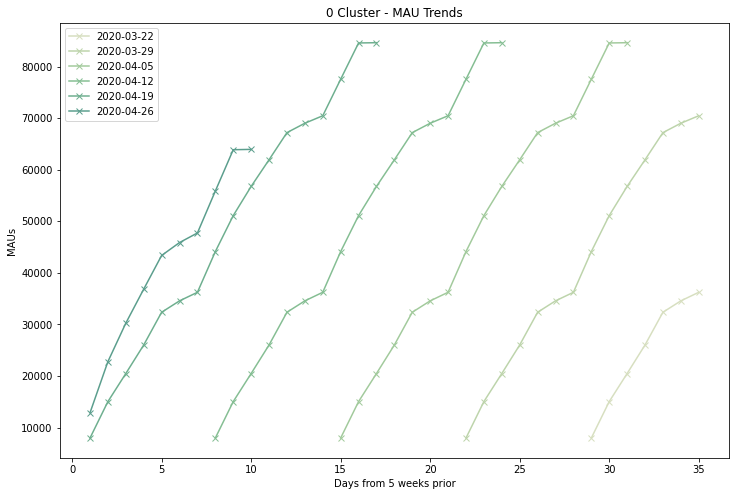

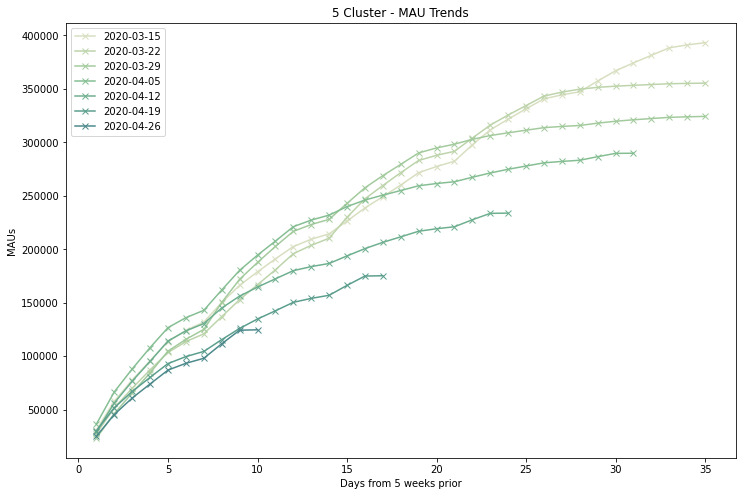

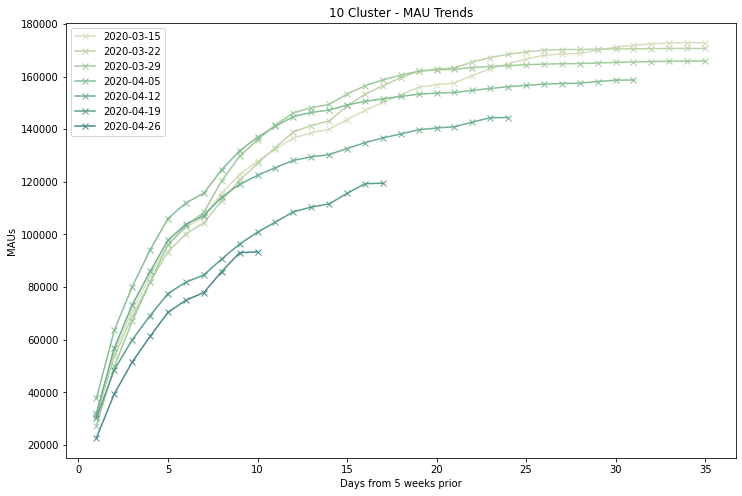

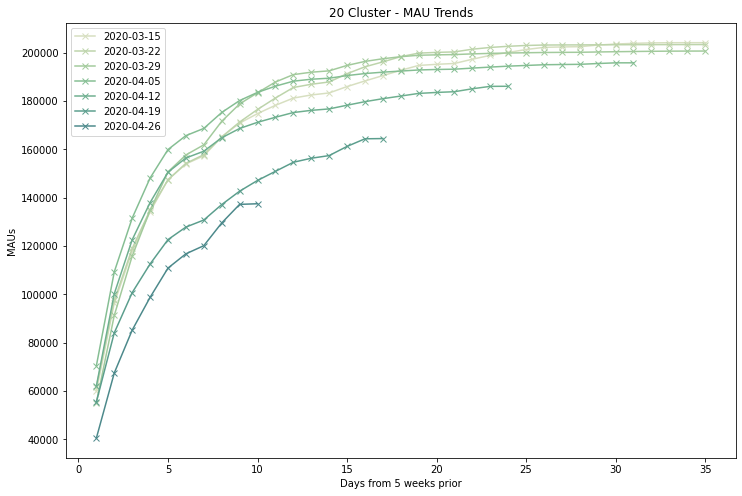

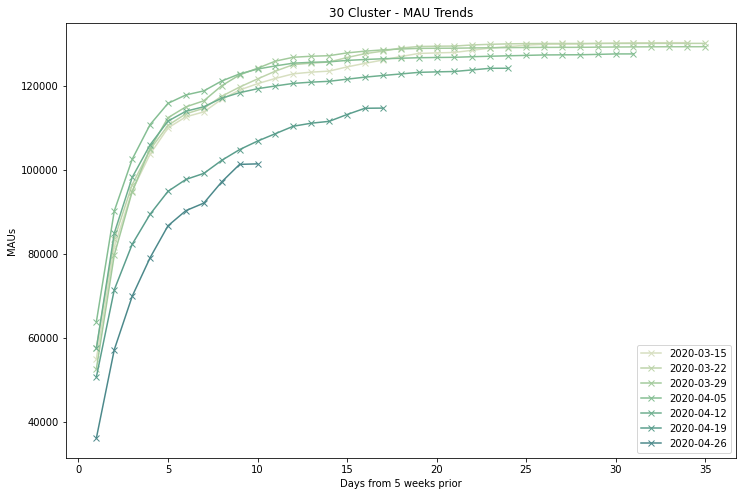

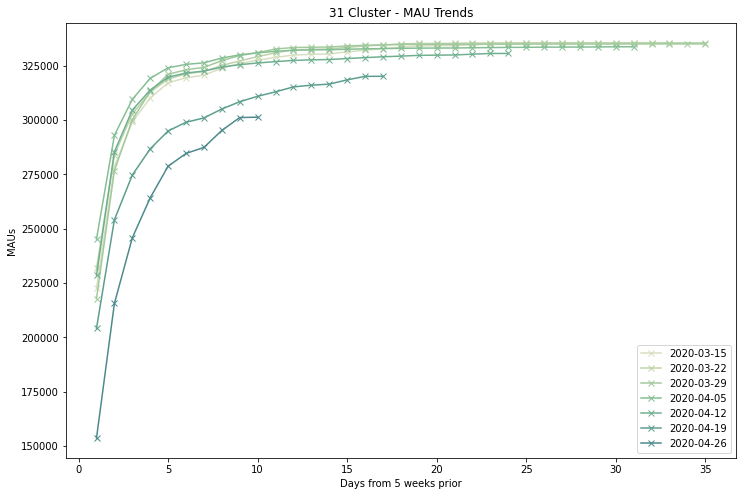

In [81]:
for c in df_txn["txn_cluster"].unique():
    plot_cluster(df_txn, "txn_cluster", c, "2020-03-15", "2020-05-01")

# Are more recent users more affected?

In [82]:
df_ten = pd.read_csv("tenure_clusters_202004021836.csv")
df_ten["n"] = df_ten["n"] + 35
df_ten.head()

tenure_cluster         w_e          dt  n  users  cumul_users    maus
0               2  2019-09-15  2019-08-12  1  39963        39963  219424
1               2  2019-09-15  2019-08-13  2  20323        60286  219424
2               2  2019-09-15  2019-08-14  3  13274        73560  219424
3               2  2019-09-15  2019-08-15  4   8910        82470  219424
4               2  2019-09-15  2019-08-16  5   7827        90297  219424

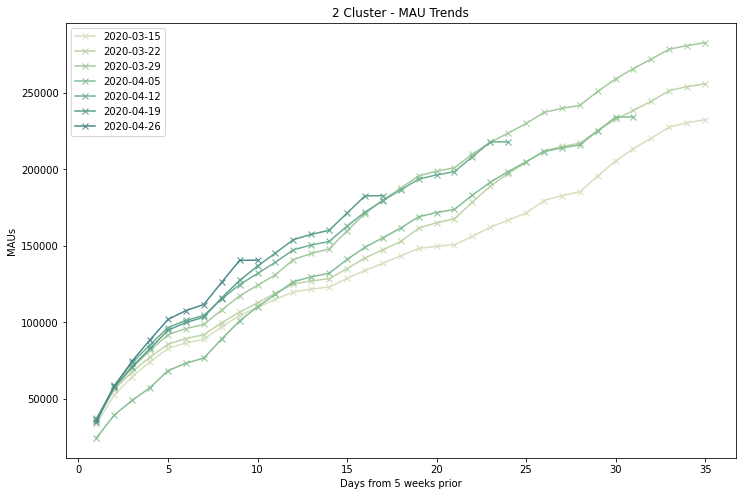

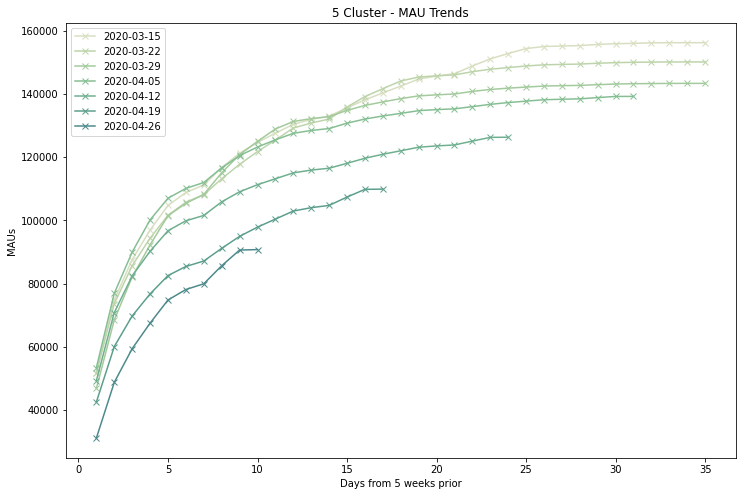

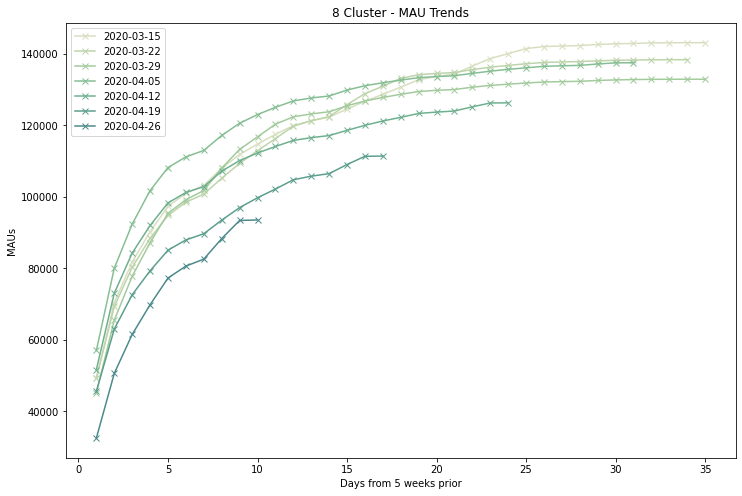

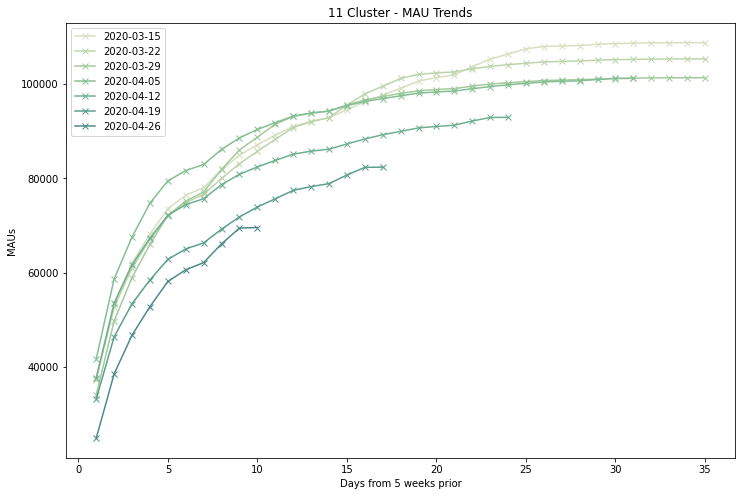

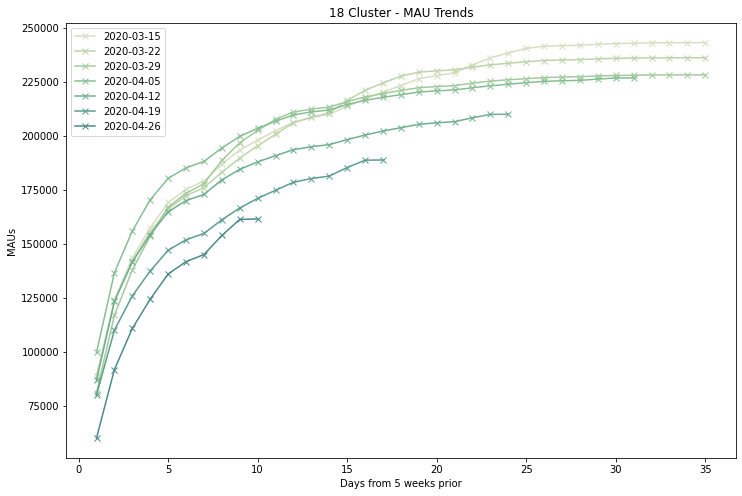

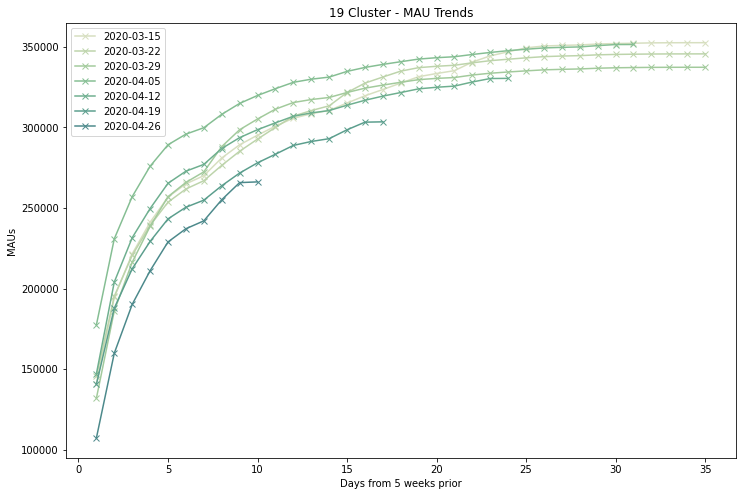

In [83]:
for c in df_ten["tenure_cluster"].unique():
    plot_cluster(df_ten, "tenure_cluster", c, "2020-03-15", "2020-05-01")

In [84]:
df_ten[df_ten["tenure_cluster"] == 2]

tenure_cluster         w_e          dt   n  users  cumul_users    maus
0                  2  2019-09-15  2019-08-12   1  39963        39963  219424
1                  2  2019-09-15  2019-08-13   2  20323        60286  219424
2                  2  2019-09-15  2019-08-14   3  13274        73560  219424
3                  2  2019-09-15  2019-08-15   4   8910        82470  219424
4                  2  2019-09-15  2019-08-16   5   7827        90297  219424
...              ...         ...         ...  ..    ...          ...     ...
1095               2  2020-04-26  2020-03-31   9  14238       140453  140655
1096               2  2020-04-26  2020-04-01  10    202       140655  140655
1097               2  2020-05-03  2020-03-30   1  27615        27615   48997
1098               2  2020-05-03  2020-03-31   2  21111        48726   48997
1099               2  2020-05-03  2020-04-01   3    271        48997   48997

[1100 rows x 7 columns]

In [ ]:
plot_cluster(df, "cluser_str", c, "2020-03-15", "2020-04-29")